In [37]:
# https://github.com/nitzanlab/prototype-equivalences.git
import os, sys
project_path = r"C:\Users\abel_\Documents\Lab\Software\prototype-equivalences"
if project_path not in sys.path:
    sys.path.append(project_path)

from NFDiffeo import Diffeo
from Hutils import get_oscillator, cycle_error
from systems import VanDerPol, PhaseSpace, Repressilator
from fit_SPE import fit_prototype

import numpy as np
import torch
from matplotlib import pyplot as plt

from scripts.homeos import *
from scripts.ra import *

import pandas as pd
import pickle

def estimate_velocities(trajectories: torch.Tensor, dt: float) -> torch.Tensor:
    # Centered finite difference (drop first and last time steps)
    dx = (trajectories[:, 2:, :] - trajectories[:, :-2, :]) / (2 * dt)
    x = trajectories[:, 1:-1, :]  # Match dx shape
    return x, dx  # Shapes: (B, T-2, N)

In [30]:
plt.rcParams.update({
    'font.family': 'sans-serif',
    'figure.dpi': 90,
    'figure.autolayout': True,
    'axes.labelsize': 18,
    'axes.titlesize': 20,
    'font.size': 18,
    'axes.linewidth': 1.5,
    'lines.linewidth': 3,
    'legend.handlelength': 2.,
    'legend.handletextpad': .4,
    'legend.labelspacing': .0,
    'legend.borderpad': .4,
    'legend.fontsize': 16,
})

def get_oscillator(a: float, omega: float, decay: float = 1, ring_type: str = 'cubic'):
    """
    Creates a function that returns a simple oscillator's vector field. If the input dimensions are larger than 2, then
    all dimensions above the first two will decay to zero.
    
    :param a: the dampening coefficient - smaller than 0 gives nodes, larger limit cycles
    :param omega: angular velocity - smaller than 0 gives counter clockwise behavior, larger gives clockwise behavior
    :param decay: how fast the "extra" dimensions decay to 0
    :return: a function that recieves as input a tensor with shape [N, dim] with dim >= 2 and outputs a tensor of the
             same dimensions, [N, dim]
    """
    def func(x: torch.Tensor):
        shape = x.shape
        x = x.reshape(x.shape[0], -1)
        decay_dims = x[..., 2:]  # Extract higher dimensions
        ra = x[..., :2]  # The first two dimensions are for the ring (r, θ)

        r = torch.sqrt(torch.sum(ra**2, dim=-1))  # Calculate the radial distance
        theta = torch.atan2(ra[..., 1], ra[..., 0])  # Calculate the angular component

        if ring_type == 'cubic':
            rdot = r * (a - r**2) # Radial dynamics: \dot{r} = r(a - r^2)
        elif ring_type == 'linear':
            rdot = r * (a - r)  # Radial dynamics: \dot{r} = r(a - r)
        else:
            raise ValueError("Invalid ring type. Choose 'cubic' or 'linear'.")

        # No angular velocity (omega = 0), so theta remains constant
        xdot = torch.cos(theta)*rdot - r*torch.sin(theta)*omega
        ydot = torch.sin(theta)*rdot + r*torch.cos(theta)*omega
        
        # Return the full dynamics, decaying the extra dimensions
        return torch.cat([xdot[..., None], ydot[..., None], -decay * decay_dims], dim=-1).reshape(shape)

    return func

def get_ring_attractor(a: float, omega = None, decay: float = 1, ring_type: str = 'cubic'):
    """
    Creates a function that returns a simple ring attractor's vector field. If the input dimensions are larger than 2, then
    all dimensions above the first two will decay to zero.
    
    :param a: Parameter defining the target radius for the ring.
    :param decay: How fast the "extra" dimensions decay to 0.
    :return: A function that receives as input a tensor with shape [N, dim] (dim >= 2) and outputs a tensor of
             the same dimensions, [N, dim].
    """
    def func(x: torch.Tensor):
        shape = x.shape
        x = x.reshape(x.shape[0], -1)
        decay_dims = x[..., 2:]  # Extract higher dimensions
        ra = x[..., :2]  # The first two dimensions are for the ring (r, θ)

        r = torch.sqrt(torch.sum(ra**2, dim=-1))  # Calculate the radial distance
        theta = torch.atan2(ra[..., 1], ra[..., 0])  # Calculate the angular component

        if ring_type == 'cubic':
            rdot = r * (a - r**2) # Radial dynamics: \dot{r} = r(a - r^2)
        elif ring_type == 'linear':
            rdot = r * (a - r)  # Radial dynamics: \dot{r} = r(a - r)
        else:
            raise ValueError("Invalid ring type. Choose 'cubic' or 'linear'.")

        # No angular velocity (omega = 0), so theta remains constant
        xdot = torch.cos(theta) * rdot
        ydot = torch.sin(theta) * rdot
        
        # Return the full dynamics, decaying the extra dimensions
        return torch.cat([xdot[..., None], ydot[..., None], -decay * decay_dims], dim=-1).reshape(shape)

    return func

class RingAttractor(PhaseSpace):
    """
    Ring Attractor:
        rdot = r(a - r^2)
        The first two dimensions evolve toward a circular limit cycle of radius sqrt(a).
        All other dimensions decay to 0 at a rate given by `decay`.
    """

    param_ranges = {
        'a': [0.5, 2.0],
        'decay': [1/6, 1]
    }

    param_display = {
        'a': r'$a$',
        'decay': r'$\lambda$'
    }

    position_lims = [-3, 3]

    def __init__(self, a: float = None, decay: float = None):
        super().__init__({'a': a, 'decay': decay})

    @staticmethod
    def random_cycle_params() -> dict:
        a = RingAttractor.param_ranges['a'][0] + \
            np.random.rand() * (RingAttractor.param_ranges['a'][1] - RingAttractor.param_ranges['a'][0])
        return {'a': a}

    def forward(self, t, z, **kwargs):
        ra = z[..., :2]
        decay_dims = z[..., 2:]

        x = ra[..., 0]
        y = ra[..., 1]

        r = torch.sqrt(x**2 + y**2 + 1e-8)  # avoid sqrt(0) instability
        theta = torch.atan2(y, x)

        a = self.parameters['a']
        decay = self.parameters['decay']

        #if         rdot = r * (a - r**2) 
        rdot = r * (a - r)
        xdot = torch.cos(theta) * rdot
        ydot = torch.sin(theta) * rdot

        zdot = torch.cat([xdot.unsqueeze(-1), ydot.unsqueeze(-1), -decay * decay_dims], dim=-1)
        return zdot

    def dist_from_bifur(self):
        return self.parameters['a']

# np.random.seed(0)
# torch.manual_seed(0)

# n_points = 50
# system = RingAttractor(a=1.0, decay=1.0)
# x = system.rand_on_traj(system.random_x(n_points), T=3)
# # calculate velocities
# xdot = system(0, x)

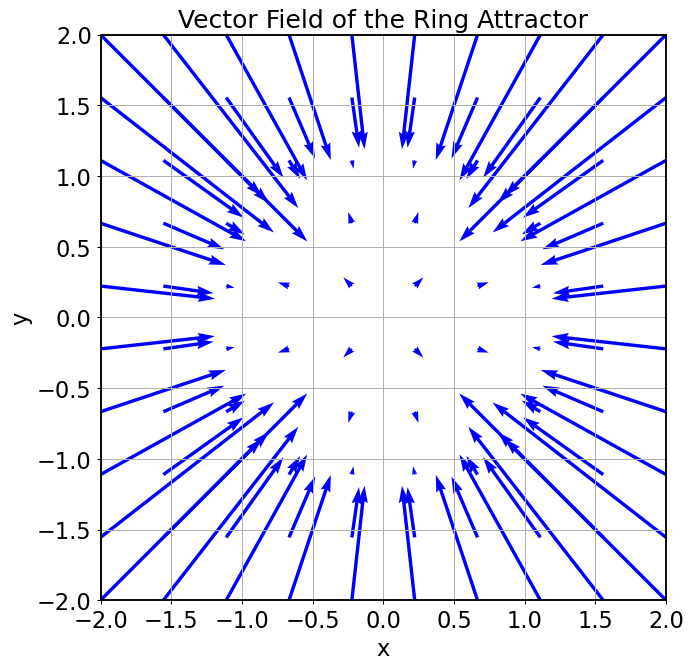

In [31]:
# Define a smaller grid
x_vals = np.linspace(-2, 2, 10)
y_vals = np.linspace(-2, 2, 10)
X, Y = np.meshgrid(x_vals, y_vals)
grid_points = np.vstack([X.flatten(), Y.flatten()]).T
grid_tensor = torch.tensor(grid_points, dtype=torch.float32)

# Get the ring attractor vector field
ring_attractor = get_ring_attractor(a=1.0, decay=1.0, ring_type='linear')
vector_field = ring_attractor(grid_tensor)

# Reshape the vector field for plotting
U = vector_field[:, 0].numpy().reshape(X.shape)
V = vector_field[:, 1].numpy().reshape(Y.shape)

# Plot the vector field
plt.figure(figsize=(8, 8))
plt.quiver(X, Y, U, V, scale=10, color="b")
plt.xlim([-2, 2])
plt.ylim([-2, 2])
plt.title("Vector Field of the Ring Attractor")
plt.xlabel("x")
plt.ylabel("y")
plt.grid(True)
plt.gca().set_aspect('equal', adjustable='box')
plt.show()


In [ ]:

def plot_trajectories(system: PhaseSpace, inits: torch.Tensor, T=30.):
    """
    Plot ground-truth trajectories from a system
    """
    traj = system.trajectories(inits, T=T, step=1e-3, euler=True).numpy()

    for i in range(traj.shape[1]):
        plt.plot(traj[:, i, 0], traj[:, i, 1], lw=3, color='k', alpha=.8, label='true trajectory' if i==0 else '')


def plot_invariant(H, a, ring_type='cubic', color='darkblue', label='predicted'):
    """
    Plots the limit cycle of radius sqrt(a), through the diffeomorphism H
    """
    if a > 0:
        angles = torch.linspace(0, 2*np.pi, 200)
        if ring_type == 'cubic':
            true_rad = np.sqrt(a)
        elif ring_type == 'linear':
            true_rad = a
        true_pts = torch.stack([
            true_rad*torch.cos(angles),
            true_rad*torch.sin(angles),
        ]).T
        cycle = H.reverse(true_pts).detach().numpy()
        plt.plot(cycle[:, 0], cycle[:, 1], lw=3, color=color, alpha=.7, label=label)
    else:
        center = H.reverse(torch.zeros(1, 2)).detach().numpy()[0]
        plt.scatter(center[0], center[1], 90, color, alpha=.7, label='pred. cycle', marker='X')


def get_inv_man(H, a, ring_type='cubic'):
    """
    Returns the invariant manifold of the ring attractor or limit cycle
    """
    angles = torch.linspace(0, 2*np.pi, 200)
    if ring_type == 'cubic':
        true_rad = np.sqrt(a)
    elif ring_type == 'linear':
        true_rad = a
    true_pts = torch.stack([
        true_rad*torch.cos(angles),
        true_rad*torch.sin(angles),
    ]).T
    cycle = H.reverse(true_pts).detach().numpy()
    return cycle

In [33]:
system_name = 'vdp'
noise_std = 0.75
simulation_params = {
    'system': 'vdp',  # Target system name
    'dim': 2,
    'mu': 0.3,  # Van der Pol parameter
    'maxT': 5.0,  # Time span for simulation
    'num_points': 50,  # Number of points in the trajectory
    'dt': 0.1,  # Time step size
    'noise_std': 0.0,  # Noise level for the simulation
    'sampling_method': 'uniform',  # Sampling method for initial conditions
    'bounds': [(-2.0, 2.0)]*2,  # Bounds for sampling
    'noise_std': noise_std,  # Noise level for the simulation
}
vdp_system = VanDerPol(mu=simulation_params['mu'])
time_span = torch.tensor([0.0, simulation_params['maxT']])
t_values, trajectories_target, initial_conditions_target = generate_trajectories(
    sampling_method=simulation_params['sampling_method'],         # Specifies the density-based sampling method
    noise_std=simulation_params['noise_std'],                     # Specifies the noise level for the simulation
    init_points_bounds=simulation_params['bounds'],                 # Define the bounds for initial conditions
    time_span=time_span, # Time span for trajectory generation
    dt=simulation_params['dt'], num_points=simulation_params['num_points'],                     # Number of initial points to sample
    system=vdp_system           # The target system, e.g., VanDerPol system
)

n_points = 500
random_indices = np.random.choice(trajectories_target.shape[0]*trajectories_target.shape[1], n_points, replace=False)
x = trajectories_target.reshape(-1, 2)[random_indices]
xdot = vdp_system(0, x)

In [34]:
save_dir = 'experiments/all_targets'
system_name = 'vdp'
dt= 0.1
# trajectories_target = np.load(f"{save_dir}/{system_name}_trajectories_target.npy")
# trajectories_target = torch.from_numpy(trajectories_target).float()
# x, xdot = estimate_velocities(trajectories_target, dt=dt)
# x = x.clone().detach().reshape(-1, 2)
# xdot = xdot.clone().detach().reshape(-1, 2)
# 
# random_indices = np.random.choice(x.shape[0], n_points, replace=False)
# print(xdot.shape)
# x = x[random_indices,:]
# xdot = xdot[random_indices,:]

a = 1
omega = -1
# fit a diffeomorphism to the given data
H, loss, ldet, score = fit_prototype(
    H=Diffeo(dim=2, n_layers=4, K=4),
    x=x,
    xdot=xdot,
    g=get_oscillator(a=a, omega=omega, ring_type='linear'),
    its=its,
    lr=lr,
    center_reg=center_reg,
    det_reg=det_reg,
    verbose=True,
    weight_decay=1e-3
)

# # extract the ground truth cycle by simulating a long path and taking only the second half
# cycle_traj = system.trajectories(x[:1], T=50)
# cycle_traj = cycle_traj[cycle_traj.shape[0]//2:][:, 0]

# # calculate the cycle error
# err = cycle_error(H, cycle_traj, a)

100%|██████████| 2500/2500 [01:21<00:00, 30.77it/s, loss=0.0060]


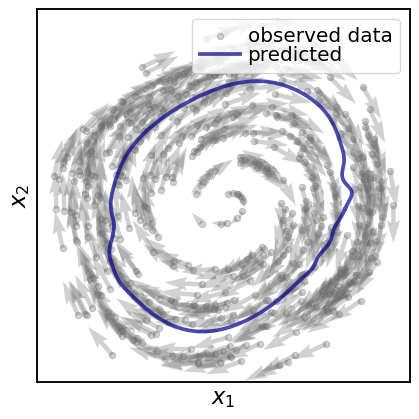

In [35]:
plt.figure(figsize=(5, 5))

# plot vectors
norms = torch.clamp(torch.norm(xdot, dim=1, keepdim=True), 1)
dy = .5*xdot/norms
x, dy = x.detach().numpy(), dy.detach().numpy()
std = np.max(x)-np.min(x)
plt.scatter(x[:, 0], x[:, 1], 25, 'dimgray', alpha=.3, label='observed data')
plt.quiver(x[:, 0], x[:, 1], dy[:, 0], dy[:, 1], scale=5, color='dimgray', alpha=.3, width=.012)

# plot trajectories
ind = np.argmax(np.abs(x[:, 0]))
#plot_trajectories(system, torch.from_numpy(x[ind:ind+1]), T=30)
plot_invariant(H, a)

plt.gca().set_xticklabels([])
plt.gca().set_yticklabels([])
plt.gca().set_xticks([])
plt.gca().set_yticks([])
plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_2$')
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

# Ring attractors

In [39]:
save_dir = "experiments/homeopert_ring"
df = pd.read_pickle(f"{save_dir}/spe_df.pkl")
all_parameters = pickle.load(open(f"{save_dir}/ring/parameters.pkl", "rb"))
simulation_params = all_parameters['simulation_params']

dt = simulation_params['dt']
all_target_trajs = []
all_target_trajs_velocities = []
for i, row in df.iterrows():
    interpol_value = row['interpol_value']
    trajectories_target = np.load(f"{save_dir}/trajectories_target_{row.interpol_value}.npy")
    #trajectories_target = torch.tensor(trajectories_target, dtype=torch.float32).detach().numpy()
    x, dx = estimate_velocities(trajectories_target, dt=dt)
    all_target_trajs.append(x)
    all_target_trajs_velocities.append(dx)

In [159]:
# fit a diffeomorphism to the given data
x = torch.tensor(all_target_trajs[0][:, :, :].reshape(-1, 2))
xdot = torch.tensor(all_target_trajs_velocities[0][:, :, :].reshape(-1, 2))
a = 1.0
H, loss, ldet, score = fit_prototype(
    H=Diffeo(dim=2, n_layers=4, K=4),
    x=x,
    xdot=xdot,
    g=get_ring_attractor(a=a, ring_type='linear'),
    its=its,
    lr=lr,
    center_reg=center_reg,
    det_reg=det_reg,
    verbose=True,
    weight_decay=1e-3
)
# extract the ground truth cycle by simulating a long path and taking only the second half
cycle_traj = system.trajectories(x[:1], T=50)
cycle_traj = cycle_traj[cycle_traj.shape[0]//2:][:, 0]
# calculate the cycle error
err = cycle_error(H, cycle_traj, a)

100%|██████████| 2500/2500 [02:17<00:00, 18.12it/s, loss=0.1464]


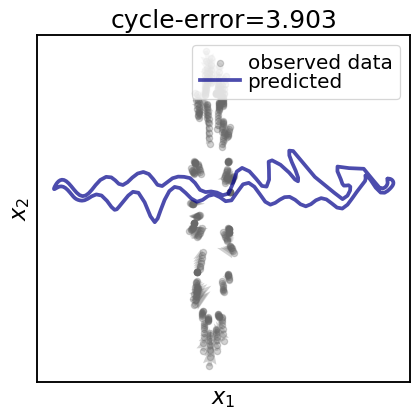

In [160]:
plt.figure(figsize=(5, 5))

x = torch.tensor(all_target_trajs[0]).reshape(-1, 2)#[:n_points]
xdot = torch.tensor(all_target_trajs_velocities[0]).reshape(-1, 2)#[:n_points]

# plot vectors
norms = torch.clamp(torch.norm(xdot, dim=1, keepdim=True), 1)
dy = .5*xdot/norms
x, dy = x.detach().numpy(), dy.detach().numpy()
std = np.max(x)-np.min(x)
plt.scatter(x[:, 0], x[:, 1], 25, 'dimgray', alpha=.3, label='observed data')
plt.quiver(x[:, 0], x[:, 1], dy[:, 0], dy[:, 1], scale=5, color='dimgray', alpha=.3, width=.012)

# plot trajectories
ind = np.argmax(np.abs(x[:, 0]))
plot_invariant(H, a)

plt.gca().set_xticklabels([])
plt.gca().set_yticklabels([])
plt.gca().set_xticks([])
plt.gca().set_yticks([])
plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_2$')
plt.legend(loc='upper right')
plt.title(f"cycle-error={err:.3f}")
plt.tight_layout()
plt.show()

In [ ]:
# fit a diffeomorphism to the given data
n_points = 500
its = 2500
lr = 1e-3
center_reg = .0
det_reg = .001
a = 1

def run_spe(target_traj_list, target_trajs_velocity_list, motif_function, a, omega=None, ring_type='linear', its=its, lr=lr, center_reg=center_reg, det_reg=det_reg, weight_decay=1e-3,
            n_layers=4, K=4, save_dir=None):
    """
    Run the SPE algorithm on the provided target trajectories and velocities.
    target_traj_list: List of target trajectories (each trajectory is a tensor).
    target_trajs_velocity_list: List of target trajectory velocities (each velocity is a tensor).
    """
    assert save_dir is not None, "Please provide a save directory."

    save_dir_homeo = "experiments/homeopert_ring"
    df_ = pd.read_pickle(f"{save_dir_homeo}/summary_df.pkl")
    df_ = df_.reset_index()  # make sure indexes pair with number of rows

    dim = target_traj_list[0].shape[-1]
    results = []
    for i, row in df_.iterrows():
        target_ra_points = row['target_ra_points']
        interpol_value =  row['interpol_value']
        x = torch.tensor(target_traj_list[i]).reshape(-1, 2)
        xdot = torch.tensor(target_trajs_velocity_list[i]).reshape(-1, 2)
        H, loss, ldet, score = fit_prototype(
            H=Diffeo(dim=dim, n_layers=n_layers, K=K),
            x=x,
            xdot=xdot,
            g=motif_function(a=a, omega=omega, ring_type=ring_type),
            its=its,
            lr=lr,
            center_reg=center_reg,
            det_reg=det_reg,
            verbose=True,
            weight_decay=weight_decay
        )

        inv_man_fit = get_inv_man(H, a, ring_type='linear')
        jac_norm = jacobian_norm_over_batch(H, x, p=2)

        results.append({
            "interpol_value": interpol_value,
            "train_loss": loss,
            #"test_loss": test_loss,
            "jacobian_norm": jac_norm,
            "score": score,
            #"grad_norms": grad_norms,
            "fit_ra_points": inv_man_fit,
            "target_ra_points": target_ra_points,
        })
        
    df = pd.DataFrame(results)
    df.to_pickle(f"{save_dir}/spe_df.pkl")

    return df


In [176]:
save_dir = "experiments/homeopert_ring"

df = run_spe(target_traj_list=all_target_trajs, target_trajs_velocity_list=all_target_trajs_velocities, motif_function=get_ring_attractor, a=1, omega=None,
              ring_type='linear', its=its, lr=lr, save_dir=save_dir)

100%|██████████| 2500/2500 [03:19<00:00, 12.55it/s, loss=0.1599]


Computing Jacobian norms...


100%|██████████| 2500/2500 [02:38<00:00, 15.77it/s, loss=0.2314]


Computing Jacobian norms...


100%|██████████| 2500/2500 [03:47<00:00, 11.00it/s, loss=0.1320]


Computing Jacobian norms...


100%|██████████| 2500/2500 [02:42<00:00, 15.40it/s, loss=0.0585]


Computing Jacobian norms...


100%|██████████| 2500/2500 [03:58<00:00, 10.48it/s, loss=0.1837]


Computing Jacobian norms...


100%|██████████| 2500/2500 [02:39<00:00, 15.69it/s, loss=0.1376]


Computing Jacobian norms...


100%|██████████| 2500/2500 [04:00<00:00, 10.40it/s, loss=0.2226]


Computing Jacobian norms...


100%|██████████| 2500/2500 [02:30<00:00, 16.66it/s, loss=0.3417]


Computing Jacobian norms...


100%|██████████| 2500/2500 [03:50<00:00, 10.85it/s, loss=0.3101]


Computing Jacobian norms...


100%|██████████| 2500/2500 [02:21<00:00, 17.70it/s, loss=0.5601]


Computing Jacobian norms...


100%|██████████| 2500/2500 [03:16<00:00, 12.72it/s, loss=0.6702]


Computing Jacobian norms...


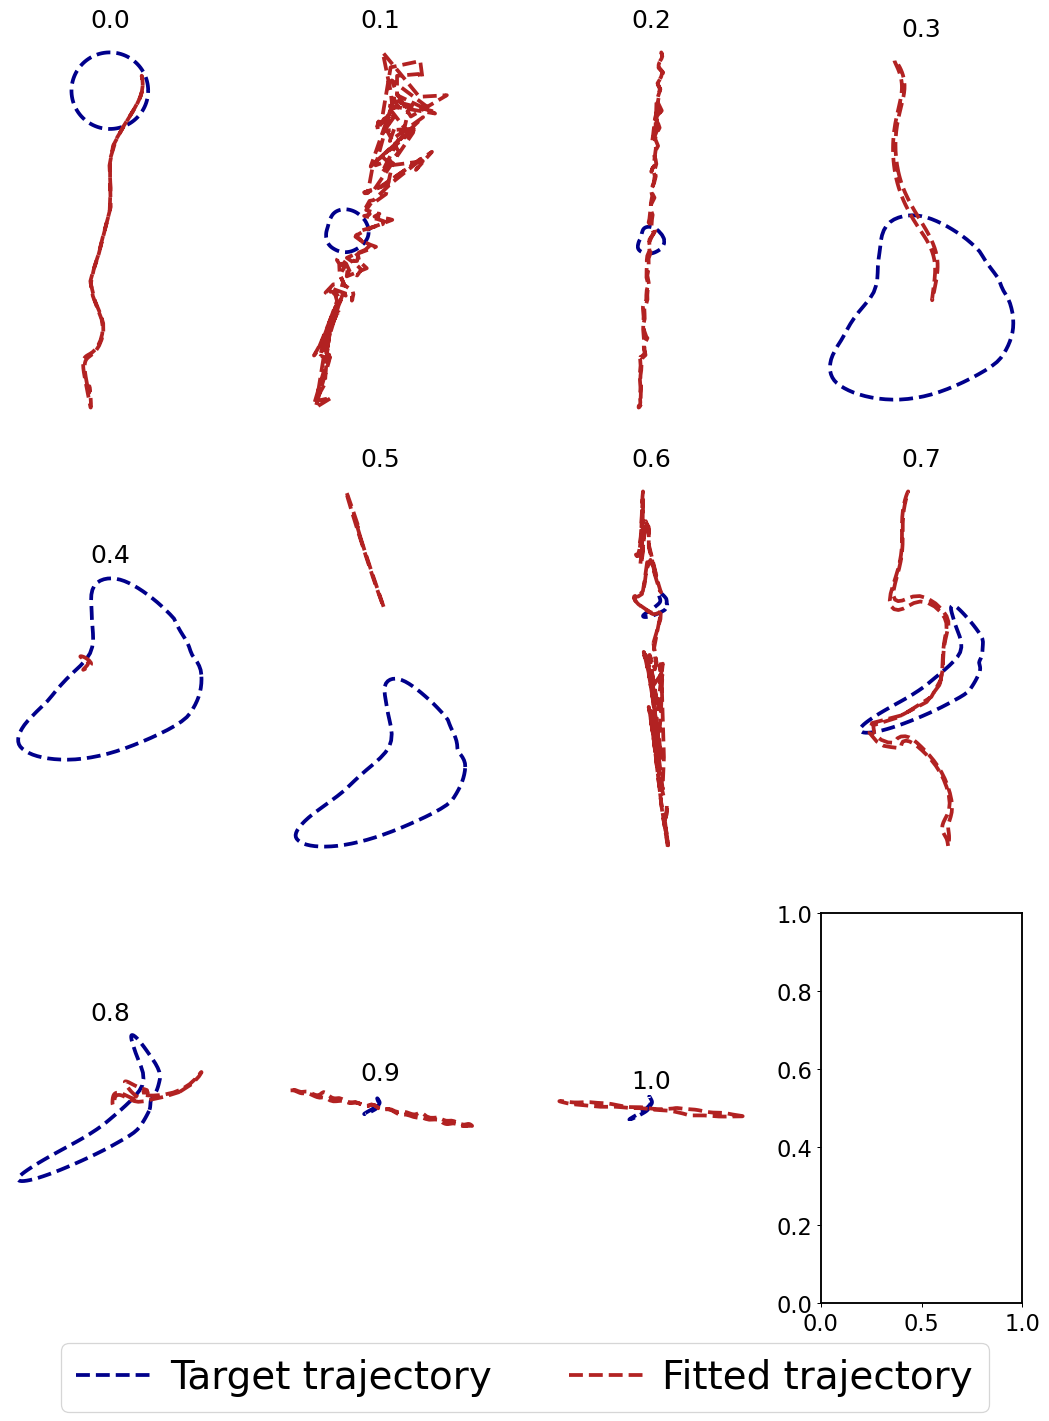

In [28]:
save_dir = "experiments/homeopert_ring"
df = pd.read_pickle(f"{save_dir}/spe_df.pkl")
last_rows = df.reset_index(drop=True)

fig, axes = plt.subplots(3, 4, figsize=(12, 16))
axes = axes.flatten()

# For collecting handles and labels
legend_handles = []
legend_labels = []

for i, (ax, row) in enumerate(zip(axes, last_rows.iterrows())):
    row = row[1]  # iterrows() gives (index, row)

    #trajectories_target = np.load(f"{save_dir}/trajectories_target_{row.p_norm}.npy")
    #l1 = ax.plot(trajectories_target[:, :, 0].T, trajectories_target[:, :, 1].T, 'r-', lw=2, alpha=0.5, label='Target trajectory')
    #traj_trans_np = np.load(f"{save_dir}/traj_motif_transformed_{row.p_norm}.npy") 
    #l2 = ax.plot(traj_trans_np[:, :, 0].T, traj_trans_np[:, :, 1].T, 'b-', lw=2, alpha=0.5, label='Fitted trajectory')

    fit_ra_points = row['fit_ra_points']
    target_ra_points = row['target_ra_points']
    l3 = ax.plot(target_ra_points[:, 0], target_ra_points[:, 1], '--', color='darkblue', label='Target RA')
    l4 = ax.plot(fit_ra_points[:, 0], fit_ra_points[:, 1], '--', color='firebrick', label='Fitted RA')

    # Collect legend handles from first plot only
    if i == 0:
        legend_handles.extend([l3[0], l4[0]])
        legend_labels.extend(['Target trajectory', 'Fitted trajectory', 'Target ring', 'Fitted ring'])

    ax.set_title(f"{row.interpol_value:.1f}")
    ax.set_aspect('equal')
    ax.axis('off')

# Add a single global legend
fig.legend(legend_handles, legend_labels, loc='lower center', ncol=4, fontsize='xx-large', bbox_to_anchor=(0.5, -0.05))

plt.tight_layout()
plt.subplots_adjust(top=0.92)
plt.savefig(f"{save_dir}/deformed_both_trajectories_asy_spe.pdf", dpi=300, bbox_inches='tight')
plt.show()

In [18]:

# from scripts.plotting import plot_jacobian_norms
# df_spe = df
# save_dir_homeo = "experiments/homeopert_ring"
# df_ = pd.read_pickle(f"{save_dir_homeo}/summary_df.pkl")
# df_spe['target_jacobian_norm'] = df_['target_jacobian_norm']

# plot_jacobian_norms(df, save_dir=save_dir, save_name=f"jacobian_norms_spe.pdf")

In [ ]:

dim = 2
maxT = 5
tsteps = maxT*20
max_perturbation_norm = .15
pring_simulation_params = {"maxT": maxT, "tsteps": tsteps, "perturbation_norm": 0.01,
    "random_seed": 313, "min_val_sim": 3, "n_grid": 40,
    "add_limit_cycle": False,
    "num_points_invman": 200,
    "number_of_target_trajectories": 50, "initial_conditions_mode": "random", "init_margin": 0.25}

results = []
save_dir = "experiments/vf_pert_ring/simple_ra"
n_points = 50
for p_norm in np.arange(0., max_perturbation_norm + 0.001, 0.01):  # steps of 0.01
    p_norm = round(p_norm, 2)
    pring_simulation_params['perturbation_norm'] = p_norm
    print(f"Perturbation norm: {p_norm}")
    print("Creating perturbed ring attractor...")
    X, Y, U_pert, V_pert, grid_u, grid_v, perturb_grid_u, perturb_grid_v, full_grid_u, full_grid_v, inv_man, trajectories_pertring = build_perturbed_ringattractor(**pring_simulation_params) 
    trajectories_target = torch.tensor(trajectories_pertring, dtype=torch.float32)
    
    #select n_points random points from the grid
    grid_size = X.shape[0] * X.shape[1]  # 1600
    random_indices = np.random.choice(grid_size, n_points, replace=False)
    rows, cols = np.unravel_index(random_indices, X.shape)
    selected_X = X[rows, cols]
    selected_Y = Y[rows, cols]
    selected_points = np.stack([selected_X, selected_Y], axis=1)
    selected_velocities = np.stack([U_pert[rows, cols], V_pert[rows, cols]], axis=1)

    x = torch.tensor(selected_points, dtype=torch.float32).reshape(-1, 2)
    xdot = torch.tensor(selected_velocities, dtype=torch.float32).reshape(-1, 2)

    # fit a diffeomorphism to the given data
    H, loss, ldet, score = fit_prototype(
        H=Diffeo(dim=dim, n_layers=4, K=4),
        x=x,
        xdot=xdot,
        g=get_ring_attractor(a=a, ring_type='linear'),
        its=its,
        lr=lr,
        center_reg=center_reg,
        det_reg=det_reg,
        verbose=True,
        weight_decay=1e-3
    )

    inv_man_fit = get_inv_man(H, a, ring_type='linear')
    jac_norm = jacobian_norm_over_batch(H, x, p=2)
    

    results.append({
        "p_norm": p_norm,
        "train_loss": loss,
        #"test_loss": test_loss,
         "jacobian_norm": jac_norm,
        "score": score,
        #"grad_norms": grad_norms,
        "fit_ra_points": inv_man_fit,
        "target_ra_points": inv_man,
    })
    
df = pd.DataFrame(results)
df.to_pickle(f"{save_dir}/pse_df.pkl")


Perturbation norm: 0.0
Creating perturbed ring attractor...


100%|██████████| 2500/2500 [02:01<00:00, 20.53it/s, loss=0.0000]


Perturbation norm: 0.01
Creating perturbed ring attractor...


100%|██████████| 2500/2500 [01:35<00:00, 26.31it/s, loss=0.0399]


Perturbation norm: 0.02
Creating perturbed ring attractor...


100%|██████████| 2500/2500 [01:47<00:00, 23.24it/s, loss=0.0402]


Perturbation norm: 0.03
Creating perturbed ring attractor...


100%|██████████| 2500/2500 [02:38<00:00, 15.73it/s, loss=0.0416]


Perturbation norm: 0.04
Creating perturbed ring attractor...


100%|██████████| 2500/2500 [01:40<00:00, 24.99it/s, loss=0.0752]


Perturbation norm: 0.05
Creating perturbed ring attractor...


100%|██████████| 2500/2500 [01:47<00:00, 23.30it/s, loss=0.0404]


Perturbation norm: 0.06
Creating perturbed ring attractor...


100%|██████████| 2500/2500 [03:20<00:00, 12.47it/s, loss=0.0420]


Perturbation norm: 0.07
Creating perturbed ring attractor...


100%|██████████| 2500/2500 [02:17<00:00, 18.24it/s, loss=0.0023]


Perturbation norm: 0.08
Creating perturbed ring attractor...


100%|██████████| 2500/2500 [01:55<00:00, 21.71it/s, loss=0.2031]


Perturbation norm: 0.09
Creating perturbed ring attractor...


100%|██████████| 2500/2500 [02:38<00:00, 15.82it/s, loss=0.0486]


Perturbation norm: 0.1
Creating perturbed ring attractor...


100%|██████████| 2500/2500 [02:03<00:00, 20.19it/s, loss=0.0816]


Perturbation norm: 0.11
Creating perturbed ring attractor...


100%|██████████| 2500/2500 [01:54<00:00, 21.82it/s, loss=0.0025]


Perturbation norm: 0.12
Creating perturbed ring attractor...


100%|██████████| 2500/2500 [02:57<00:00, 14.06it/s, loss=nan]  


Perturbation norm: 0.13
Creating perturbed ring attractor...


100%|██████████| 2500/2500 [02:40<00:00, 15.59it/s, loss=0.1995]


Perturbation norm: 0.14
Creating perturbed ring attractor...


100%|██████████| 2500/2500 [01:58<00:00, 21.10it/s, loss=0.0025]


Perturbation norm: 0.15
Creating perturbed ring attractor...


100%|██████████| 2500/2500 [01:58<00:00, 21.12it/s, loss=0.2003]


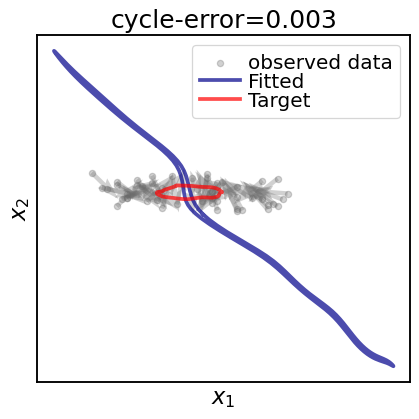

In [146]:
plt.figure(figsize=(5, 5))

# plot vectors
norms = torch.clamp(torch.norm(xdot, dim=1, keepdim=True), 1)
dy = .5*xdot/norms
xnp, dy = x.detach().numpy(), dy.detach().numpy()
std = np.max(xnp)-np.min(xnp)
plt.scatter(xnp[:, 0], xnp[:, 1], 25, 'dimgray', alpha=.3, label='observed data')
plt.quiver(xnp[:, 0], xnp[:, 1], dy[:, 0], dy[:, 1], scale=5, color='dimgray', alpha=.3, width=.012)

# plot trajectories
# ind = np.argmax(np.abs(x[:, 0]))
plot_invariant(H, a, ring_type='linear', label='Fitted')
#plot ring
plt.plot(inv_man[:, 0], inv_man[:, 1], lw=3, color='red', alpha=.7, label='Target')

plt.gca().set_xticklabels([])
plt.gca().set_yticklabels([])
plt.gca().set_xticks([])
plt.gca().set_yticks([])
plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_2$')
plt.legend(loc='upper right')
plt.title(f"cycle-error={err:.3f}")
plt.tight_layout()
plt.show()

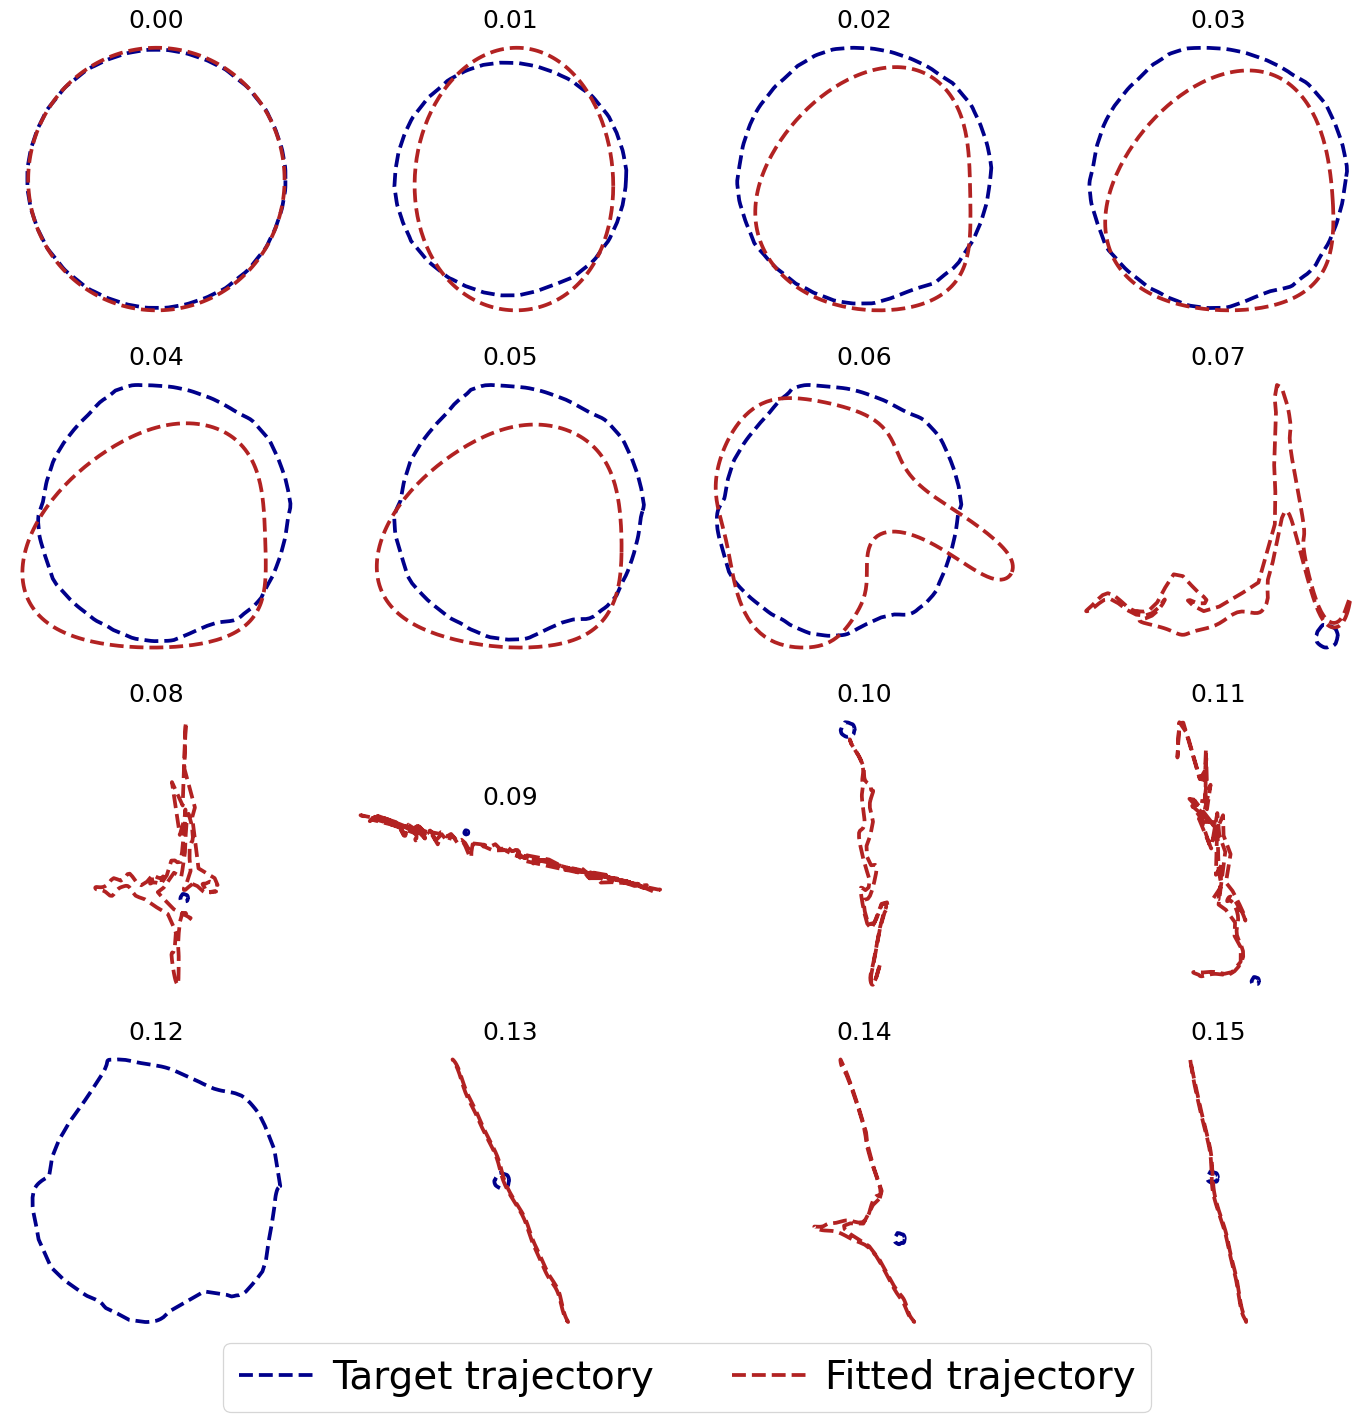

In [27]:
save_dir = "experiments/vf_pert_ring/simple"
df = pd.read_pickle(f"{save_dir}/spe_df.pkl")

last_rows = df.reset_index(drop=True)

fig, axes = plt.subplots(4, 4, figsize=(16, 16))
axes = axes.flatten()

# For collecting handles and labels
legend_handles = []
legend_labels = []

for i, (ax, row) in enumerate(zip(axes, last_rows.iterrows())):
    row = row[1]  # iterrows() gives (index, row)

    #trajectories_target = np.load(f"{save_dir}/trajectories_target_{row.p_norm}.npy")
    #l1 = ax.plot(trajectories_target[:, :, 0].T, trajectories_target[:, :, 1].T, 'r-', lw=2, alpha=0.5, label='Target trajectory')
    #traj_trans_np = np.load(f"{save_dir}/traj_motif_transformed_{row.p_norm}.npy") 
    #l2 = ax.plot(traj_trans_np[:, :, 0].T, traj_trans_np[:, :, 1].T, 'b-', lw=2, alpha=0.5, label='Fitted trajectory')

    fit_ra_points = row['fit_ra_points']
    target_ra_points = row['target_ra_points']
    l3 = ax.plot(target_ra_points[:, 0], target_ra_points[:, 1], '--', color='darkblue', label='Target RA')
    l4 = ax.plot(fit_ra_points[:, 0], fit_ra_points[:, 1], '--', color='firebrick', label='Fitted RA')

    # Collect legend handles from first plot only
    if i == 0:
        legend_handles.extend([l3[0], l4[0]])
        legend_labels.extend(['Target trajectory', 'Fitted trajectory', 'Target ring', 'Fitted ring'])

    ax.set_title(f"{row.p_norm:.2f}")
    ax.set_aspect('equal')
    ax.axis('off')

# Add a single global legend
fig.legend(legend_handles, legend_labels, loc='lower center', ncol=4, fontsize='xx-large', bbox_to_anchor=(0.5, -0.05))

plt.tight_layout()
plt.subplots_adjust(top=0.92)
plt.savefig(f"{save_dir}/perturbed_both_trajectories_asy_spe.pdf", dpi=300, bbox_inches='tight')
plt.show()
